[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/DataImaging)

# Import libs

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

# import keras
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# from keras.optimizers import Adam
# from keras.callbacks import TensorBoard

# from sklearn.model_selection import train_test_split
# import tensorflow as tf

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

---
# Data preparation

## load data

In [2]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [70]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [4]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [5]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the images from the labels

## split the training data into train and validate

In [6]:
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

X_train = train_data[:, 1:] / 1
y_train = train_data[:, 0]

X_test = test_data[:, 1:] / 1#/128#/255
y_test = test_data[:, 0]

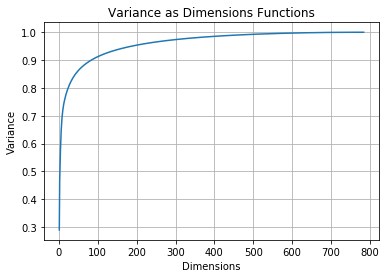

In [72]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [8]:
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train)

# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

d = len(pca.singular_values_)
pca2 = PCA(n_components=d)
X_test_pca = pca2.fit_transform(X_test)
d

84

# run again with pca!!!!!!!!!!!

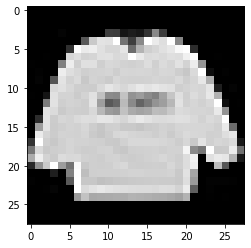

In [9]:
first_image = X_train[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [10]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [11]:
# x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [12]:
def evaluate(true, pred):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))

In [13]:
# len(predictions)
# y_test
# evaluate(y_test, predictions)

---
# Models

## Declare funcs

In [14]:
model_dict = {}

In [30]:
def score_models(model_name, model_scores):
    model_dict.update({model_name: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [54]:
def best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
#         model_score = model_dict[key].mean()
        try:   
            model_score=model_dict[key]['test_score'].mean()
        except IndexError: # remove this
            model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    print('the best model is {} with the score of {}'.format(best_key, max_score))

## Run The Models

### Naive Bayes

In [63]:
gnb = GaussianNB()

gnb.fit(X_train_pca, y_train)
predictions = gnb.predict(X_test_pca)
evaluate(y_test, predictions)

gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=5)

score_models('GaussianNB', gnb_scores)

confusion_matrix:
 [[741   0  18  44  25   2  62  11  97   0]
 [  8 337   1 559   7   3  50   1  34   0]
 [ 21   0 458   1 171   7 206   9 127   0]
 [139 115  13 525  62  15  69   3  59   0]
 [ 13   0  91  16 651   3 173   1  50   2]
 [  6   0   1   0   0 733  31 132  84  13]
 [237   1  77  18 130  12 434   6  84   1]
 [  1   0   2   0   0 240   8 582  50 117]
 [ 11   0  98   0  20  30  33  60 727  21]
 [  6   0   1   0   0  38  16  72  90 777]]
              precision    recall  f1-score   support

         0.0       0.63      0.74      0.68      1000
         1.0       0.74      0.34      0.46      1000
         2.0       0.60      0.46      0.52      1000
         3.0       0.45      0.53      0.49      1000
         4.0       0.61      0.65      0.63      1000
         5.0       0.68      0.73      0.70      1000
         6.0       0.40      0.43      0.42      1000
         7.0       0.66      0.58      0.62      1000
         8.0       0.52      0.73      0.61      1000
         

In [16]:
# mnb = MultinomialNB()
# mnb.fit(X_train_pca, y_train)
# predictions = mnb.predict(X_test_pca)
# evaluate(y_test, predictions)

### Random Forest

In [64]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=100)

# scores = cross_val_score(rf, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error')
# rf_score = np.sqrt(-scores)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=5, n_jobs=-1)

# model_dict.update({"RandomForestClassifier": rf_score})

# print("Accuracy: %0.2f (+/- %0.2f)" % (rf_score.mean(), rf_score.std() * 2))

score_models('Random Forest', rf_scores)

tmp = cross_val_predict(rf, X_train_pca, y_train, cv=5, n_jobs=-1)


# print(len(predictions))
# print(len(tmp))
# y_test_appended = np.append(np.append(y_test,y_test),np.append(np.append(y_test, y_test),np.append(y_test, y_test)))
evaluate(y_train, tmp)

Accuracy: 0.87 (+/- 0.01)
Train time: 107.75 seconds (+/- 0.98) for a total of 538.74 seconds
Test time: 0.51 seconds (+/- 0.10) for a total of 2.54 seconds
confusion_matrix:
 [[5148    2   92  220   30   12  414    0   82    0]
 [  15 5743   41  161   10    0   23    0    6    1]
 [  61    2 4855   52  614    5  348    0   63    0]
 [ 175   22   40 5398  186    1  147    0   30    1]
 [  13    4  513  243 4836    3  341    0   47    0]
 [   0    0    1    4    0 5606    1  221   25  142]
 [ 984    8  716  142  557   10 3471    1  111    0]
 [   0    0    0    0    0  204    0 5505    7  284]
 [  13    1   25   39   25   71   65   23 5728   10]
 [   0    0    0    1    0  118    0  199    4 5678]]
              precision    recall  f1-score   support

         0.0       0.80      0.86      0.83      6000
         1.0       0.99      0.96      0.97      6000
         2.0       0.77      0.81      0.79      6000
         3.0       0.86      0.90      0.88      6000
         4.0       0.7

In [18]:
# predictions_train = rf.predict(X_train_pca)
# evaluate(y_train, predictions_train)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
#now lets find the optimum K 
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=5, n_jobs=-1)['test_score']
    if scores.std() > 0.1:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

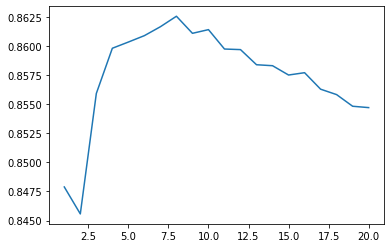

In [22]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [23]:
index = err_rate.index(min(err_rate)) + 1
index

2

In [24]:
k = KNeighborsClassifier(n_neighbors=index)
# k.fit(X_train_pca, y_train)
# predictions = k.predict(X_test_pca)

In [60]:
k_scores = cross_validate(k, X_train_pca, y_train, cv=5, n_jobs=-1)
score_models('KNN', k_scores)

Accuracy: 0.85 (+/- 0.00)
Train time: 2.54 seconds (+/- 0.05) for a total of 12.68 seconds
Test time: 56.23 seconds (+/- 0.43) for a total of 281.16 seconds


### Logistic Regression

In [59]:
lr = LogisticRegression(random_state=0)#, solver='lbfgs', penalty='l2')

lr_scores = cross_validate(lr, X_train_pca, y_train, cv=5, n_jobs=-1)

# model_dict.update({"logistic regression": lr_scores})

# print("Accuracy: %0.2f (+/- %0.2f)" % (lr_scores['test_score'].mean(), lr_scores['test_score'].std() * 2))
# print('the mean train time is {} seconds'.format(lr_scores['fit_time'].mean()))
# print('the mean test time is {} seconds'.format(lr_scores['score_time'].mean()))

score_models('Logistic Regression', lr_scores)

# lr2_score = scores
# print("Accuracy: %0.2f (+/- %0.2f)" % (lr2_score.mean(), lr2_score.std() * 2))

# tmp = cross_val_predict(lr2, X_train_pca, y_train, cv=5, n_jobs=-1)
# tmp

# print(len(predictions))
# print(len(tmp))
# # y_test_appended = np.append(np.append(y_test,y_test),np.append(np.append(y_test, y_test),np.append(y_test, y_test)))
# evaluate(y_train, tmp)


Accuracy: 0.84 (+/- 0.00)
Train time: 22.18 seconds (+/- 0.29) for a total of 110.90 seconds
Test time: 0.02 seconds (+/- 0.01) for a total of 0.10 seconds


### SVC

In [32]:
svc = SVC(random_state=0, max_iter=500)
# svc.fit(X_train, y_train)
# predictions = svc.predict(X_test)
# evaluate(y_test, predictions)

svc_scores = cross_validate(svc, X_train_pca, y_train, cv=5, n_jobs=-1)
score_models('SVC', svc_scores)

Accuracy: 0.80 (+/- 0.03)
Train time: 179.61 seconds (+/- 1.02) for a total of 898.05 seconds
Test time: 57.05 seconds (+/- 0.46) for a total of 285.24 seconds


### Decision Tree

In [33]:
dtc = DecisionTreeClassifier()
# dtc.fit(X_train, y_train)
# predictions = dtc.predict(X_test)
# evaluate(y_test, predictions)

dtc_scores = cross_validate(svc, X_train_pca, y_train, cv=5, n_jobs=-1)
score_models('Decision Tree', dtc_scores)


Accuracy: 0.80 (+/- 0.03)
Train time: 180.49 seconds (+/- 1.27) for a total of 902.46 seconds
Test time: 55.89 seconds (+/- 0.45) for a total of 279.46 seconds


### Gradient Boosting

In [56]:
gb = GradientBoostingClassifier(random_state=0)
gb_scores = cross_validate(svc, X_train_pca, y_train, cv=5, n_jobs=-1)
score_models('Gradient Boosting', gb_scores)

Accuracy: 0.80 (+/- 0.03)
Train time: 217.61 seconds (+/- 1.62) for a total of 1088.03 seconds
Test time: 87.83 seconds (+/- 0.79) for a total of 439.16 seconds


## Find Best Model

In [57]:
best_model()

0.7715000000000001
0.8661333333333333
0.8455666666666668
0.8432000000000001
0.7984000000000001
0.7984000000000001
0.7984000000000001
the best model is RandomForestClassifier with the score of 0.8661333333333333


## Improve The Model

### Ada Boost

## Test The Model On The Test Data

In [61]:
rf.fit(X_train_pca, y_train)
predictions = rf.predict(X_test_pca)
evaluate(y_test, predictions)

confusion_matrix:
 [[797   4  20  65  12   7  69   0  13  13]
 [ 12 535   8 408   7   0  28   0   2   0]
 [ 14   1 626   5 146   3 145   1  59   0]
 [ 61  79  11 754  49   3  37   0   1   5]
 [  3   6 127  39 725   0  86   0  14   0]
 [  2   0   1   2   0 901   2  23  50  19]
 [236   1 125  34 165   2 407   0  29   1]
 [  0   0   0   0   0 416   0 262 225  97]
 [ 14   1 199  13  61  87  47  66 469  43]
 [  2   0   0   0   1  64   0  50  67 816]]
              precision    recall  f1-score   support

         0.0       0.70      0.80      0.74      1000
         1.0       0.85      0.54      0.66      1000
         2.0       0.56      0.63      0.59      1000
         3.0       0.57      0.75      0.65      1000
         4.0       0.62      0.72      0.67      1000
         5.0       0.61      0.90      0.73      1000
         6.0       0.50      0.41      0.45      1000
         7.0       0.65      0.26      0.37      1000
         8.0       0.50      0.47      0.49      1000
         